In [1]:
import numpy as np
import time
import pandas as pd 
import matplotlib.pyplot as plt
import math 
import random
import scipy.io as spio
import collections
from sklearn.model_selection import train_test_split

columns = ['coluna 1', 'coluna 2']
train = pd.read_csv("cluster.dat", decimal=".", sep=' ', names=columns)
eps = 0.005
minpts = 10

In [2]:
def normalize(data):
  normData = data.copy()
  for i in range(data.shape[1]):
    normData.iloc[:,i] /= np.linalg.norm(data.iloc[:,i])
  return normData

In [3]:
def split_dataset(data, p=0.9): 
  embaralhado = data.iloc[np.random.permutation(len(data))]
  d1 = embaralhado.iloc[0:int(embaralhado.shape[0]*p),:]
  d2 = embaralhado.iloc[int(embaralhado.shape[0]*p):,:]
  return d1,d2


In [4]:
def module(i, j):
    return np.linalg.norm(i - j)
def distance_two_points (i,j):
    return math.sqrt(abs(sum(i**2-j**2)))
def distance(V):
    return math.sqrt(sum(v**2 for v in V))

In [29]:
def ExpandClusters(data, points_labels, id_seed, neighbor_points, C, epsilon, min_pts, core_points):
    # coloca o id do cluster no ponto atual
    points_labels[id_seed] = C
   
    i = 0
    while i < len(neighbor_points):        
        next_position = neighbor_points[i]
        if points_labels[next_position] == -1:
           points_labels[next_position] = C
        
        # se o ponto vizinho ainda nao tinha cluster agora ele tem
        elif points_labels[next_position] == 0:
            points_labels[next_position] = C
            
            pn_neighbor = [i for i in range(len(data)) if np.linalg.norm(data.iloc[i,:]-data.iloc[next_position,:]) <= epsilon]
            #se o ponto tem filhos, adiciona eles na fila 
            if len(pn_neighbor) > min_pts:
                neighbor_points = neighbor_points + pn_neighbor
                core_points.append(next_position) # = np.append(core_points, next_position,dtype = int)
        i += 1
    return core_points

In [25]:
def effDBSCAN(data, epsilon, minP):
  C = 0
  point_label = np.zeros(len(data),dtype=int) 
  core_points = []
  for p in range(len(data)):
    if point_label[p] != 0: continue
    current_point = data.iloc[p]
    # armazena os pontos vizinhos ao ponto p.
    neighbor_points = [i for i in range(len(data)) if np.linalg.norm(data.iloc[i,:]-current_point) <= epsilon]
  
    # o ponto nao tem vizinhos o suficiente
    if len(neighbor_points) <= minP:
      point_label[p] = -1
    # tem vizinhos o suficiente para criar um novo clusters
    else:
      C += 1
      core_points.append(p) # = np.append(core_points, p)
      core_points = ExpandClusters(data, point_label, p, neighbor_points, C, epsilon, minP, core_points)

  return point_label, core_points, C


In [7]:
#Function to plot final result
def plotRes(train, point_labels, main_title):
  dicColors = {0:'black', 1:'orange', 2:'purple', 3:'red', 4:'blue', 5:'green', 
              6:'yellow', 7:'violet', 8:'brown'}    
  label_color = [dicColors[c%9] for c in point_labels] 
  x_label = 'x axis'
  y_label = 'y axis'
  title = main_title 
  plt.figure(figsize=(15,15))
  plt.scatter(train.iloc[:,0],train.iloc[:,1],c=label_color,alpha=0.3)
  plt.suptitle(title, fontsize=20)
  plt.suptitle(title, fontsize=20)  
  plt.suptitle(title, fontsize=20)  
  plt.savefig(title + '.png')
  plt.show()

In [8]:
def callPlot(train_data,pointlabel, main_title):
  cl = len(pointlabel)
  plotRes(train_data, pointlabel, main_title) 
  plt.show()
  print('number of cluster found: ' + str(cl-1))
  counter=collections.Counter(pointlabel)
  print(counter)
  outliers  = np.count_nonzero(pointlabel == 0)
  print('number of outliers found: '+str(outliers) +'\n')

In [36]:
# checar depois: https://gist.github.com/AlexandreAbraham/5544803
def find_clusters_and_centroids_all_pts(norm_dataset, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in range(len(norm_dataset)):    
        # clusters[point_labels[0][i]] = np.append(clusters[point_labels[0][i]], i)
        if point_labels[i] == -1:
            point_labels[i] = 0
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset.iloc[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

def find_clusters_and_centroids(norm_dataset, core_points, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in core_points:    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset.iloc[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

In [69]:
def dist_intra_clusters_index (norm_data, clusters, centroids, i):
  B = [[abs(norm_data.iloc[round(clusters[i][j])] - centroids[i][0]) 
          for j in range(len(clusters[i]))]
           ] # for i in range(len(clusters))]
  return B

# search for math.dist(p, q) later :)
def dist_intra_clusters(norm_data, clusters, centroids):
    centroids = np.asarray(centroids)
    B = 0
    dist = 0
    elbow = 0
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if not math.isnan(clusters[i][j]) and not math.isnan(centroids[i][0][0]): 
                # soma += np.abs(norm_data.iloc[round(clusters[i][j])] - centroids[i][0])    
                dist += math.dist(norm_data.iloc[round(clusters[i][j])], centroids[i][0])
                elbow += dist**2
    B = soma
    return B, elbow
  

In [64]:
def dist_centroids(centroids, c1, c2):
    return abs(centroids[c1][0] - centroids[c2][0])

def dist_inter_clusters(centroids):
    centroids =np.asarray(centroids)
    A = 0
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            if not math.isnan(centroids[i][0][0]) and not math.isnan(centroids[j][0][0]): 
                # A += np.abs(centroids[i][0] - centroids[j][0])
                A += math.dist(centroids[i][0], centroids[j][0])
    return A 

In [80]:
def calc_silhouette (A, B):
    a = A
    b = B
    if (type(A) is type([])):
        a = distance(A) # distance (dist_inter_clusters(centroids))
    if (type(B) is type([])):
        b = distance(B) # ditance (dist_intra_clusters(norm_dataset, clusters, centroids))
    sil = (b - a)/(max(a, b)+0.000001)
    print("A: {}\nB: {}\na___b___sil: {}____{}____{}\n".format(A, B, a, b, sil))
    return sil
    

In [73]:
def inertia_val(v):
    return v**2
def inertia(V):
    return sum(v**2 for v in V)
def calc_elbow(B):
    if(type(B) is type(0) or type(0.)):
        return inertia_val(B)
    else:
        return inertia(B)

In [55]:
def predict(pred_dataset, norm_orig_dataset, clusters, orig_point_labels, eps):
    norm_pred_dataset = pred_dataset # normalize(pred_dataset).to_numpy()
    print(norm_pred_dataset)
    pred_point_labels = np.zeros(len(norm_pred_dataset),dtype=int)
    for i in range(len(norm_pred_dataset)):
        for j in range(len(clusters)):
            for cp in clusters[j]:
                cp = round(cp)
                dist = np.linalg.norm(norm_pred_dataset.iloc[i,:] - norm_orig_dataset.iloc[cp,:]) 

                if (dist  <= eps):
                    pred_point_labels[i] = orig_point_labels[cp] 
                    break  
    return pred_point_labels

In [74]:
def validate(dataset, 
             epsilon=[0.001, 0.003, 0.006, 0.009, 0.02, 0.04, 0.06, 0.08],
             minpts=5):
  somaDasSilhuetas = []
  somaDosQuadrados = []
  for eps in epsilon:
    print("epsilon: {}".format(eps))
    norm_dataset = dataset # normalize(dataset).to_numpy()
    point_labels, core_points, n_clusters = effDBSCAN(norm_dataset,eps,minpts)
    clusters, centroids = find_clusters_and_centroids(
                          norm_dataset, core_points, point_labels, n_clusters
    )
    inter = dist_inter_clusters(centroids)
    intra, elbow = dist_intra_clusters(norm_dataset, clusters, centroids)
    somaDosQuadrados.append(calc_elbow(elbow)) # calc_elbow(intra))
    somaDasSilhuetas.append(calc_silhouette(inter, intra))
    callPlot(dataset, point_labels, "DBSCAN clusters for eps: "+ str(eps))
  
  print("Cotovelo:")
  print(somaDosQuadrados)
  plt.plot(epsilon, somaDosQuadrados, 'x-')
  plt.xlabel('epsilon')
  plt.ylabel('Soma dos quadrados')
  
  print("Silhuetas:")
  print(somaDasSilhuetas)
  plt.plot(epsilon, somaDasSilhuetas, 'go')
  plt.xlabel('epsilon')
  plt.ylabel('Coeficiente de Silhueta')

In [20]:
# Split and initialize training & validation & test data separately
norm_train = normalize(train) # .to_numpy()
training, test = split_dataset(norm_train)
training, validation = split_dataset(training)
norm_training =  normalize(training) # .to_numpy()

In [30]:
point_labels, core_points, n_clusters = effDBSCAN(norm_train,eps,minpts)

In [32]:
point_labels_train, core_points_train, n_clusters_train = effDBSCAN(norm_training, eps, minpts)

In [37]:
clusters_train, centroids_train = find_clusters_and_centroids(
    norm_training, core_points_train, point_labels_train, n_clusters_train
)

In [42]:
point_labels_valid = predict(validation, norm_training, clusters_train, point_labels_train, eps)

     coluna 1  coluna 2
310  0.038793  0.010965
350  0.035036  0.023134
301  0.038590  0.005061
74   0.008734  0.057835
289  0.035036  0.007350
543  0.063877  0.058919
569  0.070376  0.064703
384  0.035239  0.026146
205  0.023357  0.018073
557  0.064689  0.066872
475  0.067126  0.045425
39   0.016350  0.065546
449  0.066517  0.041689
488  0.063064  0.053015
280  0.033208  0.012892
77   0.009851  0.055546
517  0.069868  0.051208
25   0.023763  0.063498
96   0.015131  0.052895
458  0.061439  0.046750
514  0.073829  0.049642
56   0.018686  0.057594
424  0.045089  0.020965
260  0.030770  0.017110
143  0.022951  0.049883
220  0.033005  0.024580
17   0.023052  0.067474
498  0.064892  0.055787
430  0.047324  0.023736
259  0.029450  0.015784
375  0.042144  0.015784
279  0.032903  0.014218
264  0.030466  0.008193
464  0.064080  0.047352
1    0.030263  0.066390
253  0.025896  0.007229
344  0.034833  0.020724
75   0.008124  0.058437
455  0.061033  0.045304
558  0.066415  0.067956
244  0.026607  0

pt_label: 3
pred_point: coluna 1    0.026607
coluna 2    0.021568
Name: 202, dtype: float64
core_pt: coluna 1    0.030135
coluna 2    0.018982
Name: 233, dtype: float64
dist: 0.004374296899991546
pt_label: 1


epsilon: 0.001
A: 0
B: 0
a___b___sil: 0____0____0.0



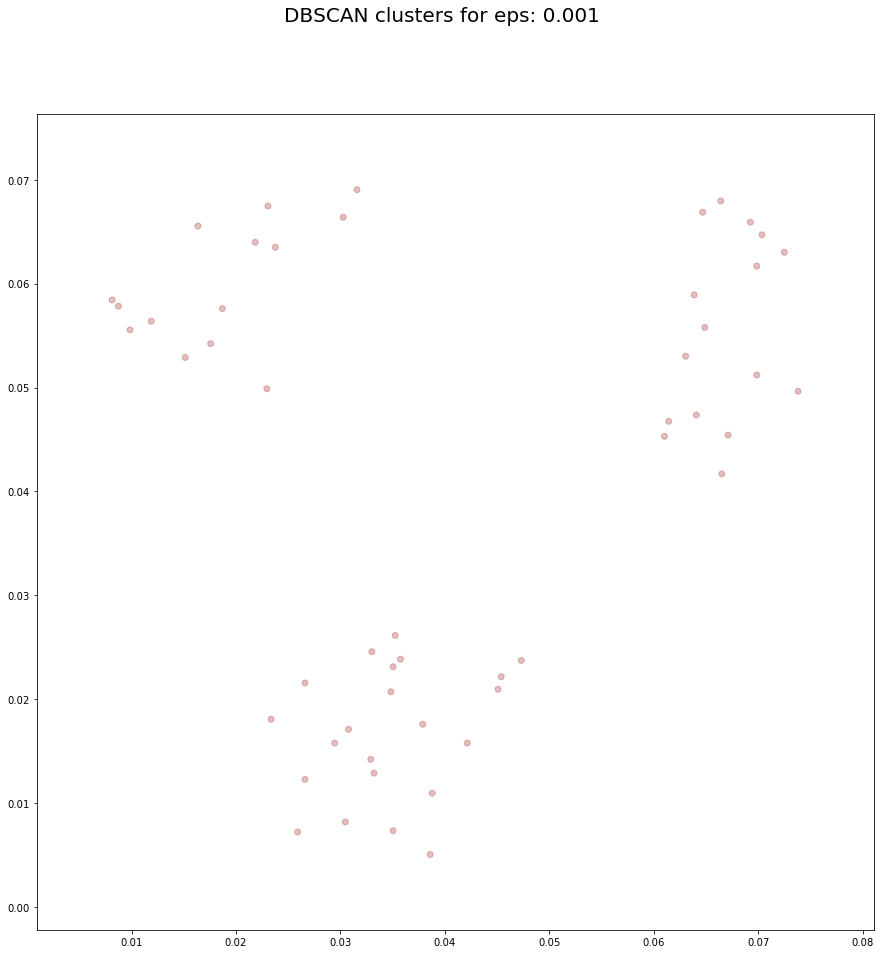

number of cluster found: 51
Counter({-1: 52})
number of outliers found: 0

epsilon: 0.003
A: 0
B: 0
a___b___sil: 0____0____0.0



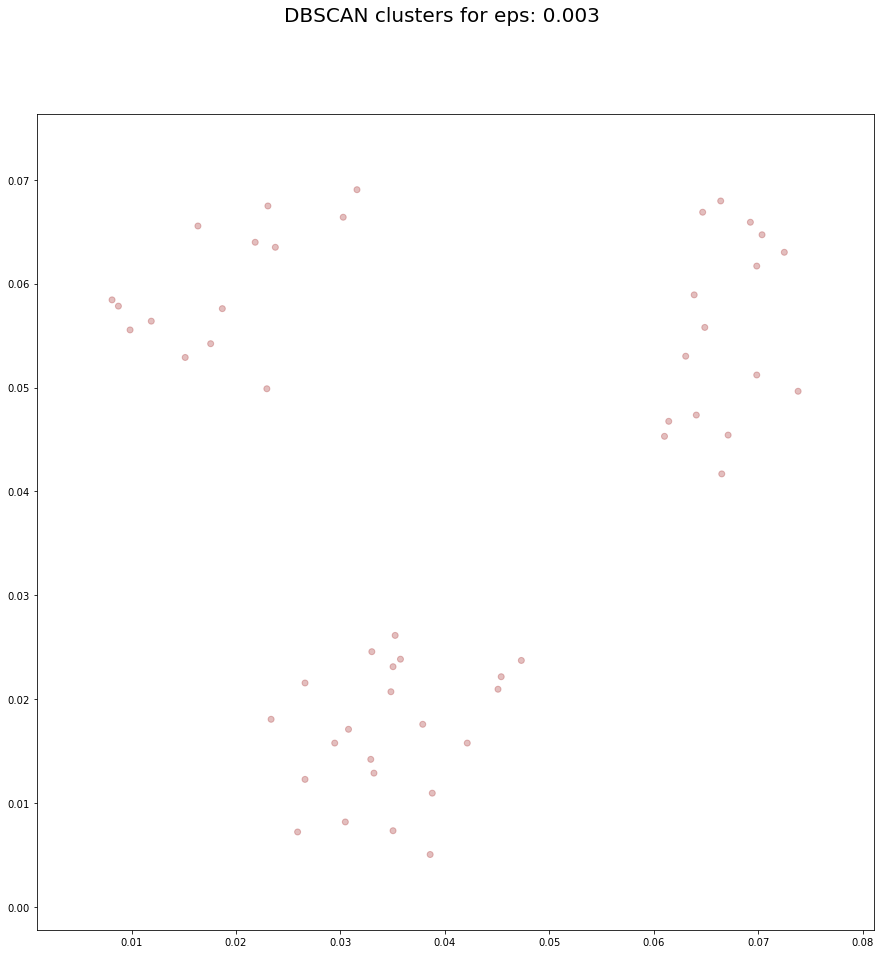

number of cluster found: 51
Counter({-1: 52})
number of outliers found: 0

epsilon: 0.006
A: 0.12891475435794897
B: 0
a___b___sil: 0.12891475435794897____0____-0.9999922429961723



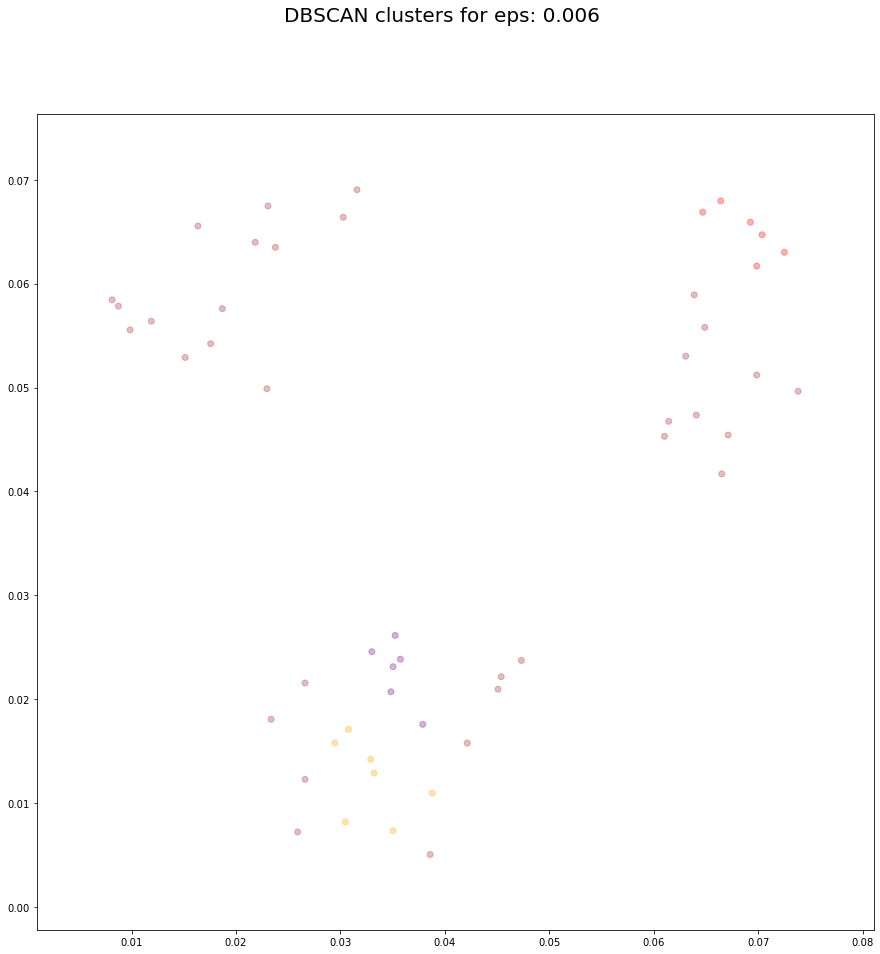

number of cluster found: 51
Counter({-1: 33, 1: 7, 2: 6, 3: 6})
number of outliers found: 0

epsilon: 0.009
A: 0.14493675738915818
B: 0
a___b___sil: 0.14493675738915818____0____-0.999993100486595



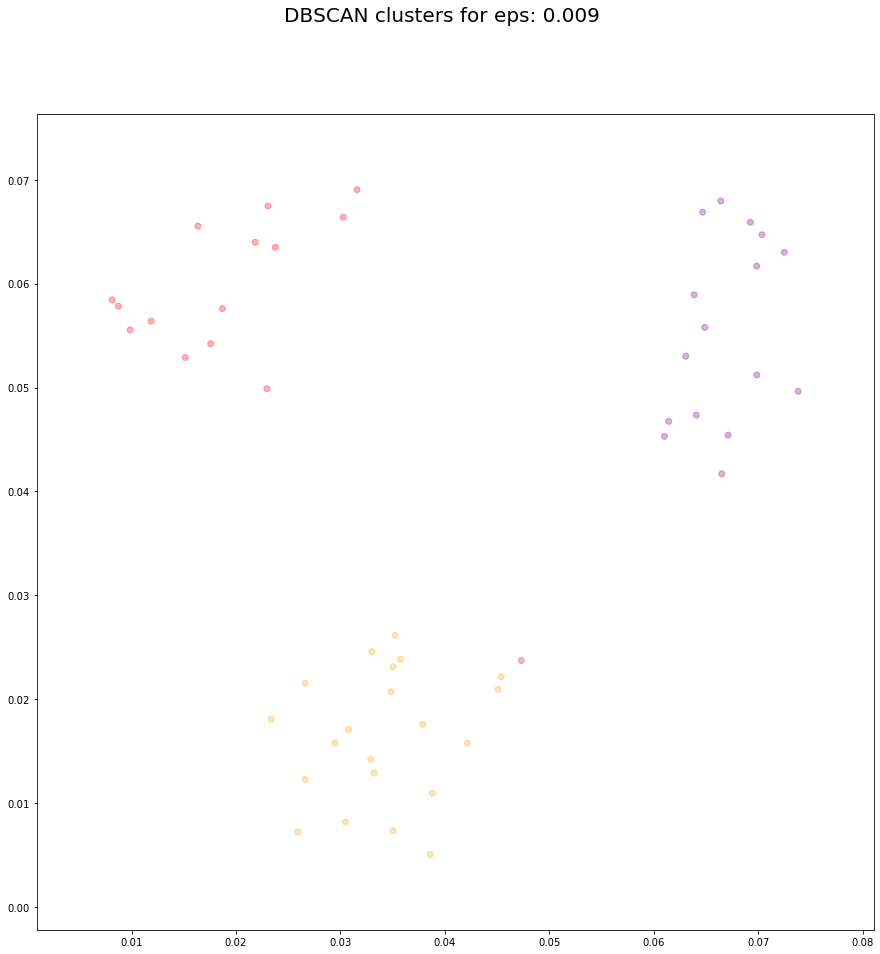

number of cluster found: 51
Counter({1: 21, 2: 16, 3: 14, -1: 1})
number of outliers found: 0

epsilon: 0.02
A: 0.14466110559999418
B: 0
a___b___sil: 0.14466110559999418____0____-0.9999930873396605



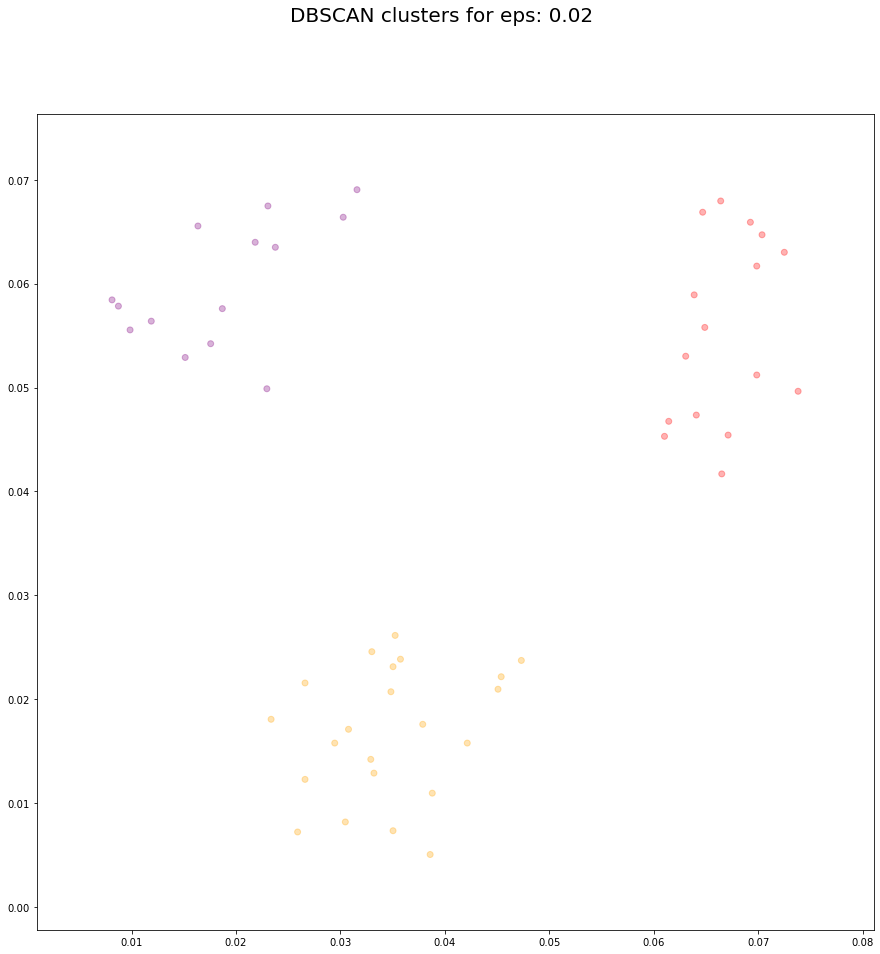

number of cluster found: 51
Counter({1: 22, 3: 16, 2: 14})
number of outliers found: 0

epsilon: 0.04
A: 0
B: 0
a___b___sil: 0____0____0.0



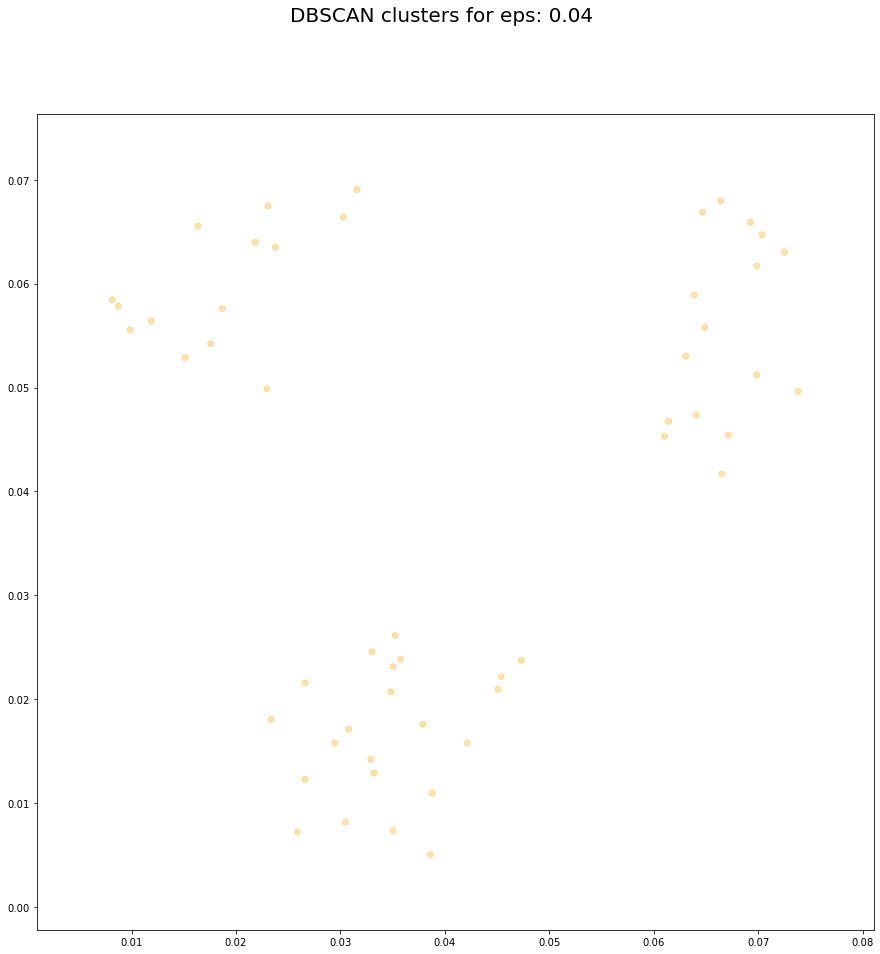

number of cluster found: 51
Counter({1: 52})
number of outliers found: 0

epsilon: 0.06
A: 0
B: 0
a___b___sil: 0____0____0.0



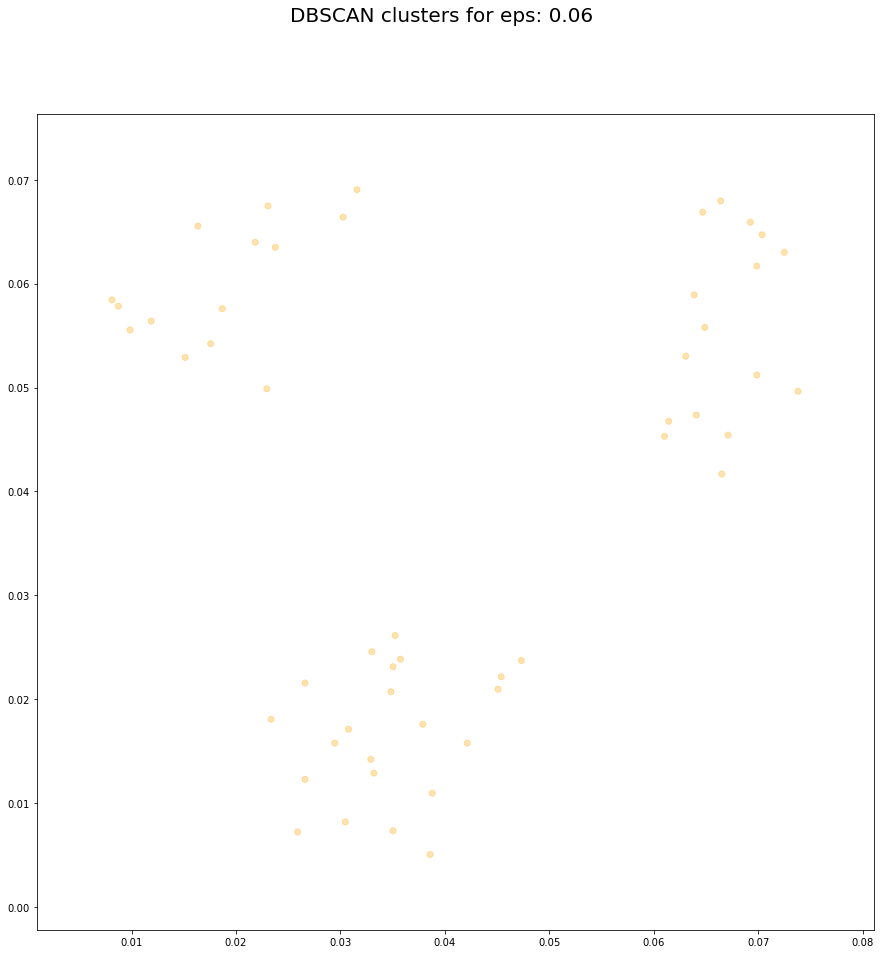

number of cluster found: 51
Counter({1: 52})
number of outliers found: 0

epsilon: 0.08
A: 0
B: 0
a___b___sil: 0____0____0.0



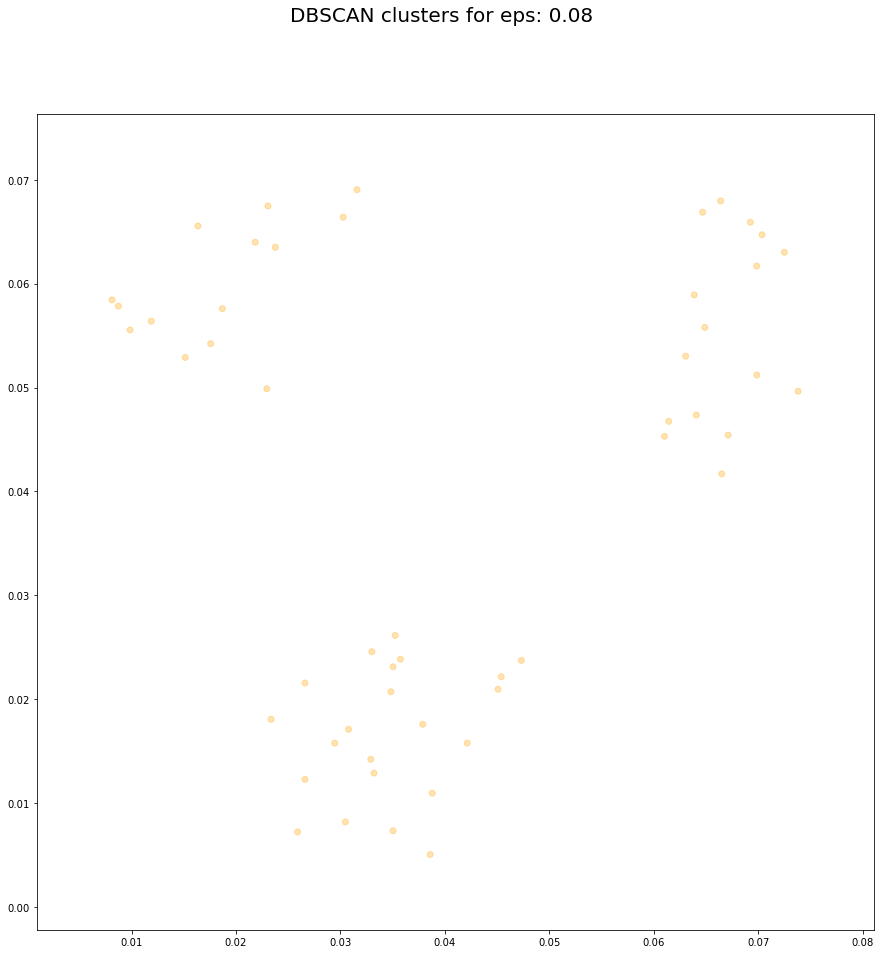

number of cluster found: 51
Counter({1: 52})
number of outliers found: 0

Cotovelo:
[0, 0, 0.0, 0.8805522425979713, 11.367221519926822, 1196.320391217978, 1351.655541961287, 1487.0174243460347]
Silhuetas:
[0.0, 0.0, -0.9999922429961723, -0.999993100486595, -0.9999930873396605, 0.0, 0.0, 0.0]


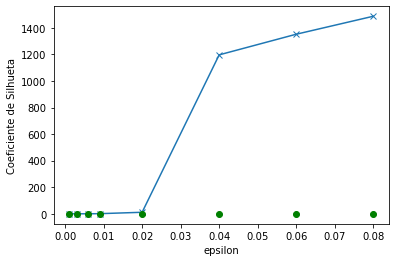

In [81]:
validate(validation)

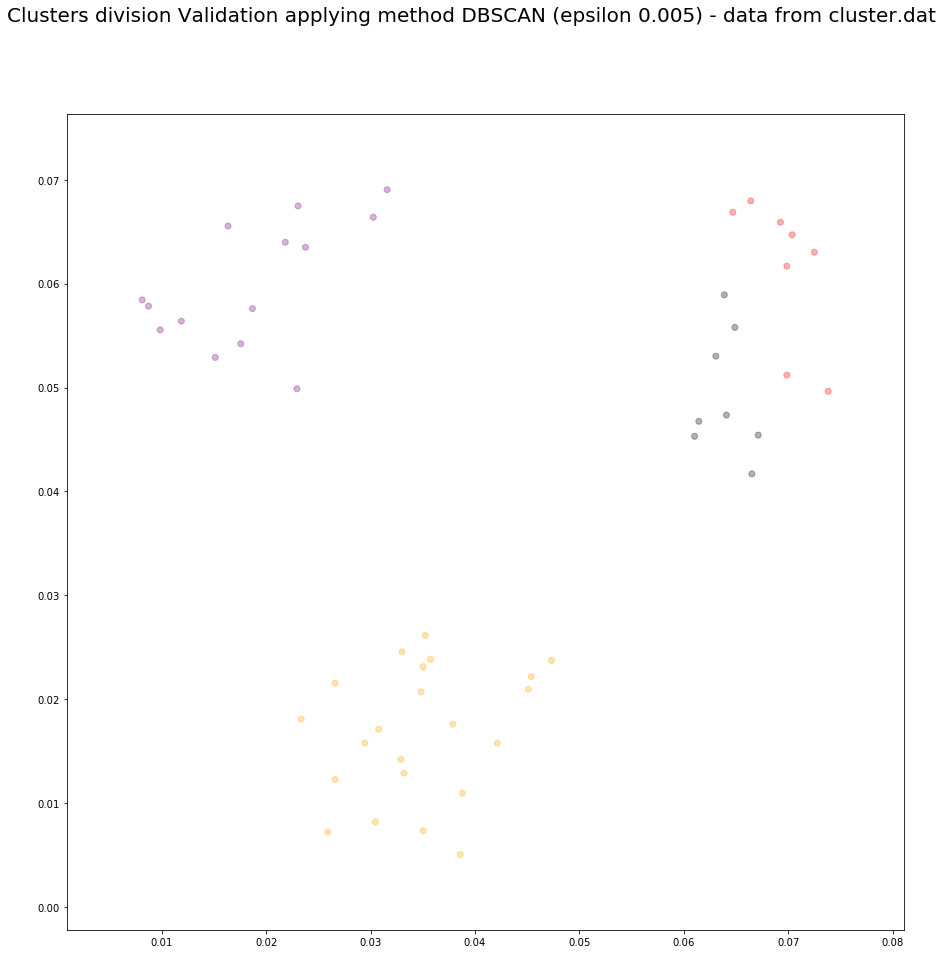

number of cluster found: 51
Counter({1: 22, 2: 14, 0: 8, 3: 8})
number of outliers found: 8



In [43]:
callPlot(validation,point_labels_valid,
     'Clusters division Validation applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

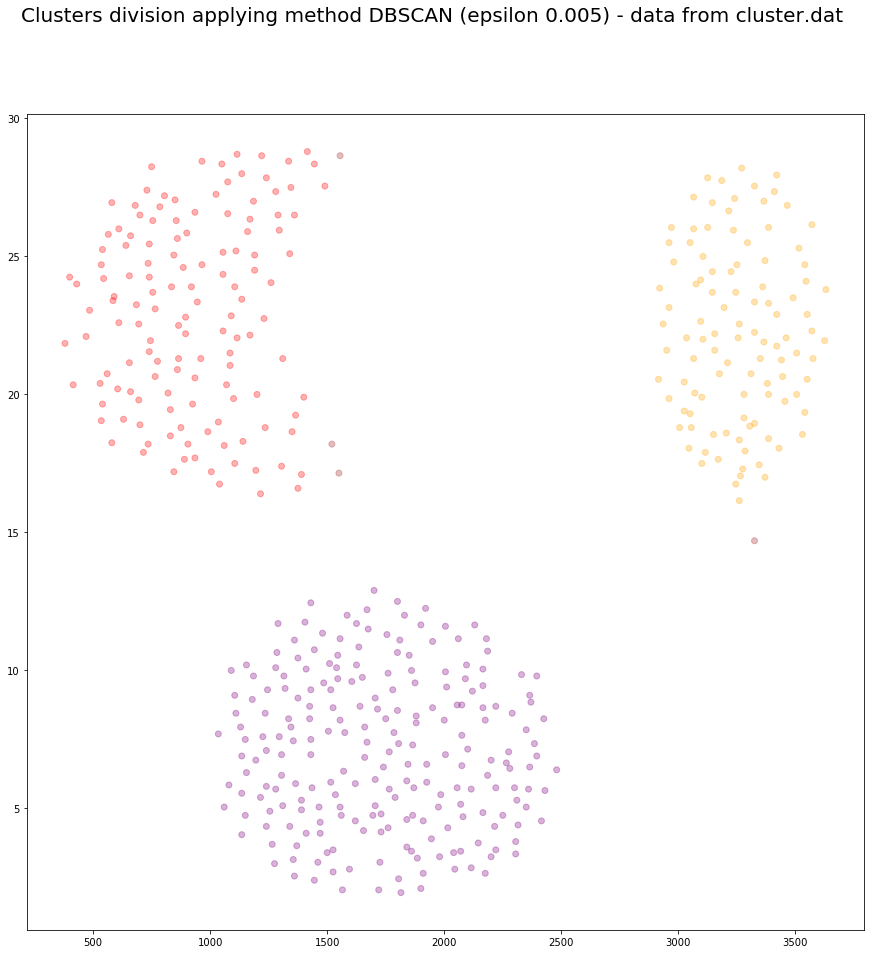

number of cluster found: 462
Counter({2: 222, 3: 133, 1: 104, -1: 4})
number of outliers found: 0



In [99]:
callPlot(norm_training,point_labels_train,
     'Clusters division applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')
# callPlot(norm_training,point_labels_train,
#     'Training Clusters division applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

In [35]:
clusters

NameError: name 'clusters' is not defined

In [4]:
A = [1,2,3,4]
B = [[1,2],[3,4]]
C = [i*(i == j) for i in A for k in B for j in k]
print(C)  

[1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4]


In [34]:
c_p = [0, 0, 0, 1, 1, 1, 2, 2]
n_p_d = [1, 3, 7]
e = 1

pt_labels = np.zeros(len(n_p_d),dtype=int)
 
for j in range(len(n_p_d)):
    for i in range(1,len(c_p)):
        if (module(n_p_d[j], c_p[i])  <= e):
            pt_labels[j] = n_p_d[j] 
            break              

print(pt_labels)

pt_labels = [ # boolean check - however, it will be gigant
            n_p_d[j]*
            (module(n_p_d[j], c_p[i])  <= e) 
            for i in range(1,len(c_p)) 
            for j in range(len(n_p_d))
            ]
print(pt_labels)

[1 3 0]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 3, 0, 1, 3, 0]


In [25]:
print(module(n_p_d[0], c_p[1]))

1.0


In [63]:
centroids_train

[[coluna 1   NaN
  coluna 2   NaN
  dtype: float64],
 [coluna 1    0.040316
  coluna 2    0.019450
  dtype: float64],
 [coluna 1    0.020551
  coluna 2    0.062740
  dtype: float64],
 [coluna 1    0.075381
  coluna 2    0.060455
  dtype: float64]]

In [ ]:
validate(train)